In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from catboost import CatBoostClassifier
import optuna
import warnings


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
data = "breast_msk.tsv"

In [4]:
df = pd.read_table(data)

In [5]:
df.head(5)

,Study ID,Patient ID,Sample ID,Cancer Type,Cancer Type Detailed,Ethnicity,Fraction Genome Altered,Sex,Gene Panel,Metastatic Site,...,Overall Survival (Months),Overall Survival Status,Primary Tumor Site,Race,Sample Class,Number of Samples Per Patient,Sample coverage,Sample Type,Somatic Status,Tumor Purity
0,breast_msk_2025,P-0000004,P-0000004-T01-IM3,Breast Cancer,Breast Invasive Ductal Carcinoma,Non-Spanish; Non-Hispanic,0.2782,FEMALE,IMPACT341,NaN,...,3.550646,1:DECEASED,Breast,WHITE,Tumor,1,428,Primary,Matched,50
1,breast_msk_2025,P-0000012,P-0000012-T02-IM3,Breast Cancer,Breast Invasive Ductal Carcinoma,Non-Spanish; Non-Hispanic,0.3146,Female,IMPACT341,NaN,...,132.656081,0:LIVING,Breast,White,Tumor,1,344,Primary,Matched,NaN
2,breast_msk_2025,P-0000015,P-0000015-T01-IM3,Breast Cancer,Breast Invasive Ductal Carcinoma,Non-Spanish; Non-Hispanic,0.3503,FEMALE,IMPACT341,Liver,...,13.676562,1:DECEASED,Breast,WHITE,Tumor,1,281,Metastasis,Matched,40
3,breast_msk_2025,P-0000041,P-0000041-T01-IM3,Breast Cancer,Breast Invasive Ductal Carcinoma,Non-Spanish; Non-Hispanic,0.4041,FEMALE,IMPACT341,NaN,...,13.314923,1:DECEASED,Breast,WHITE,Tumor,1,401,Primary,Matched,30
4,breast_msk_2025,P-0000057,P-0000057-T01-IM3,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Non-Spanish; Non-Hispanic,0.4286,FEMALE,IMPACT341,NaN,...,29.161324,1:DECEASED,Breast,WHITE,Tumor,1,835,Primary,Matched,25


In [6]:
# Convert Tumor Purity to numeric
df['Tumor Purity'] = pd.to_numeric(df['Tumor Purity'], errors='coerce')



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3879 entries, 0 to 3878
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Study ID                       3879 non-null   object 
 1   Patient ID                     3879 non-null   object 
 2   Sample ID                      3879 non-null   object 
 3   Cancer Type                    3879 non-null   object 
 4   Cancer Type Detailed           3879 non-null   object 
 5   Ethnicity                      3879 non-null   object 
 6   Fraction Genome Altered        3841 non-null   float64
 7   Sex                            3879 non-null   object 
 8   Gene Panel                     3879 non-null   object 
 9   Metastatic Site                2031 non-null   object 
 10  MSI Comment                    2385 non-null   object 
 11  MSI Score                      3786 non-null   float64
 12  MSI Type                       3788 non-null   o

In [8]:
df.describe()

,Fraction Genome Altered,MSI Score,Mutation Count,Overall Survival (Months),Number of Samples Per Patient,Sample coverage,Tumor Purity
count,3841.000000,3786.000000,3784.000000,3871.000000,3879.000000,3879.000000,3795.000000
mean,0.281697,0.957810,6.096195,46.118694,1.469709,664.246971,43.639789
std,0.189415,1.658486,6.619626,33.945864,0.723187,235.157279,18.745814
min,0.000000,-1.000000,1.000000,0.000000,1.000000,12.000000,5.000000
25%,0.129200,0.080000,3.000000,15.188875,1.000000,521.000000,30.000000
50%,0.253800,0.440000,5.000000,40.109149,1.000000,669.000000,40.000000
75%,0.406900,1.240000,7.000000,74.810139,2.000000,804.500000,60.000000
max,0.981400,46.130000,179.000000,132.656081,6.000000,2610.000000,95.000000


In [9]:
df.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Cancer Type',
       'Cancer Type Detailed', 'Ethnicity', 'Fraction Genome Altered', 'Sex',
       'Gene Panel', 'Metastatic Site', 'MSI Comment', 'MSI Score', 'MSI Type',
       'Mutation Count', 'Oncotree Code', 'Overall Survival (Months)',
       'Overall Survival Status', 'Primary Tumor Site', 'Race', 'Sample Class',
       'Number of Samples Per Patient', 'Sample coverage', 'Sample Type',
       'Somatic Status', 'Tumor Purity'],
      dtype='object')

In [10]:
# Standardize text casing
df['Sex'] = df['Sex'].str.upper()
df['Race'] = df['Race'].str.upper()
df['Ethnicity'] = df['Ethnicity'].str.upper()
df['Overall Survival Status'] = df['Overall Survival Status'].str.upper()


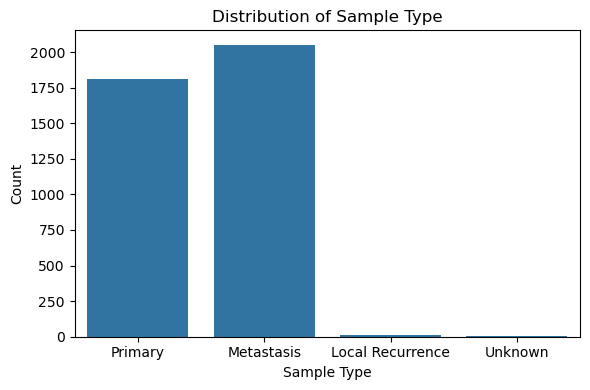

In [11]:
# Class distribution
class_counts = df['Sample Type'].value_counts()

# Basic visual EDA: Class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sample Type')
plt.title('Distribution of Sample Type')
plt.xlabel('Sample Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


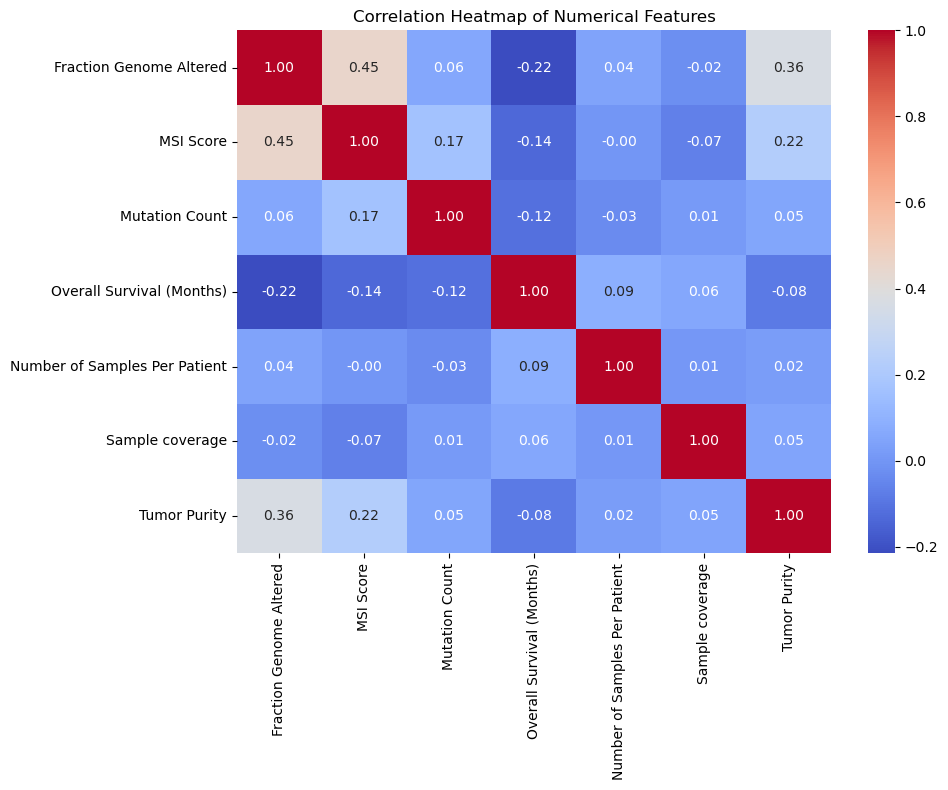

In [12]:
# Heatmap for correlation among numeric features
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

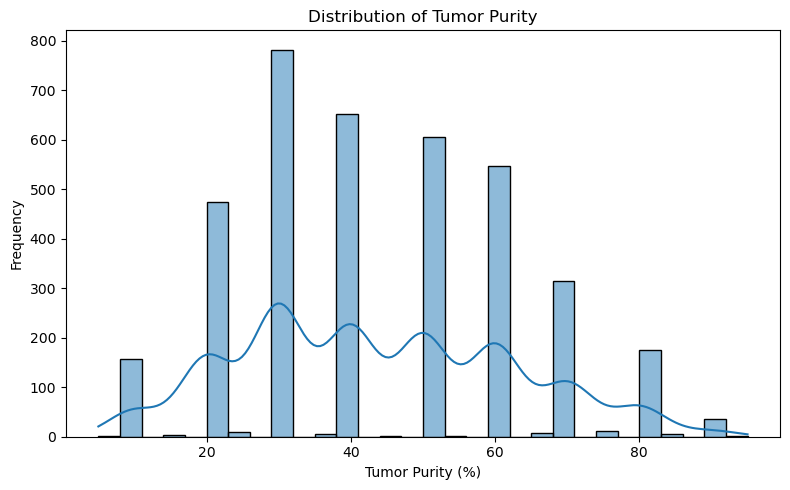

In [13]:


# 1. Distribution of Tumor Purity
plt.figure(figsize=(8, 5))
sns.histplot(df["Tumor Purity"], bins=30, kde=True)
plt.title("Distribution of Tumor Purity")
plt.xlabel("Tumor Purity (%)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


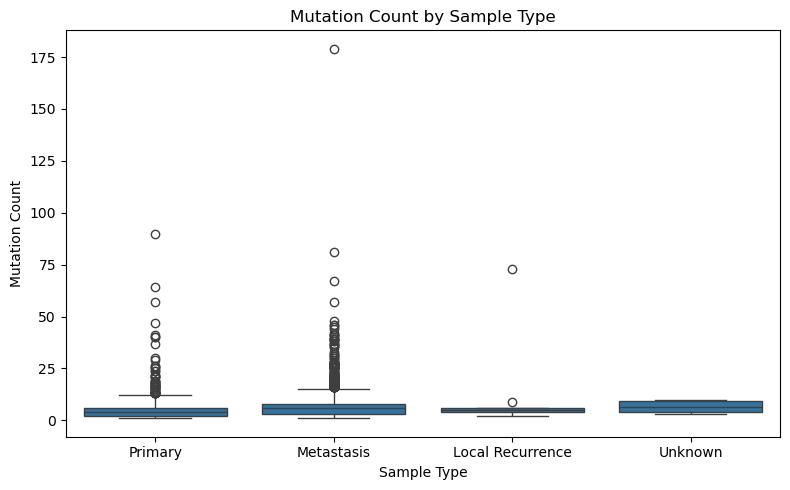

In [14]:

# 2. Boxplot of Mutation Count by Sample Type
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Sample Type", y="Mutation Count")
plt.title("Mutation Count by Sample Type")
plt.ylabel("Mutation Count")
plt.xlabel("Sample Type")
plt.tight_layout()
plt.show()


In [15]:
# Filter to include only rows with 'Primary' or 'Metastasis' Sample Types
df_filtered = df[df['Sample Type'].isin(['Primary', 'Metastasis'])].copy()

# Drop ID columns and irrelevant columns
drop_cols = ['Study ID', 'Patient ID', 'Sample ID', 'Gene Panel', 'Oncotree Code', 
             'Sample Class', 'Somatic Status', 'Sample coverage', 'MSI Comment']
df = df_filtered.drop(columns=drop_cols)

# Strip whitespace and standardize text columns
df = df.applymap(lambda x: x.strip().upper() if isinstance(x, str) else x)


In [16]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Sample Type')
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()


In [17]:
# Impute missing values
df[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_cols])
df[numerical_cols] = SimpleImputer(strategy='median').fit_transform(df[numerical_cols])


In [18]:
# Encode and scale
df_encoded = pd.get_dummies(df, columns=categorical_cols)
df_encoded['Sample Type'] = df_encoded['Sample Type'].map({'PRIMARY': 1, 'METASTASIS': 0})
X = df_encoded.drop('Sample Type', axis=1)
y = df_encoded['Sample Type']
X[numerical_cols] = StandardScaler().fit_transform(X[numerical_cols])


In [19]:
# Apply SMOTE
X_balanced, y_balanced = SMOTE(sampling_strategy=1.0, random_state=42).fit_resample(X, y)


In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

# Hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced']
}
logreg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='f1')

Logistic Regression Best Params: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88       615
           1       0.85      0.95      0.90       615

    accuracy                           0.89      1230
   macro avg       0.89      0.89      0.89      1230
weighted avg       0.89      0.89      0.89      1230

ROC-AUC Score: 0.950257122083416
Confusion Matrix:
 [[512 103]
 [ 33 582]]


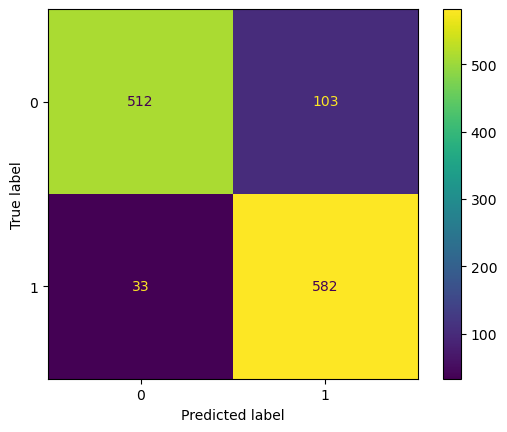

In [21]:



# Evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print("Logistic Regression Best Params:", grid_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

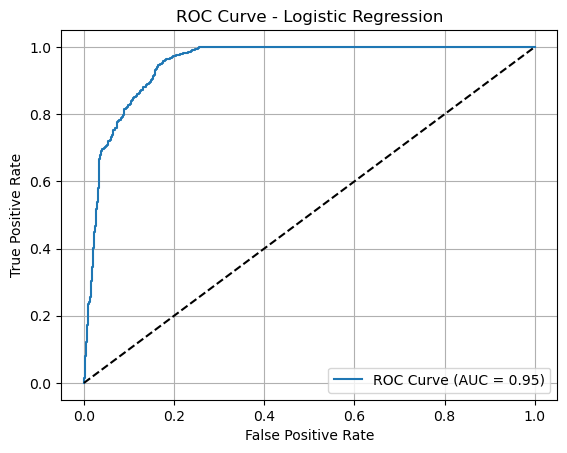

In [22]:



# Visualize ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [23]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [24]:
# Best Random Forest model
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_proba = rf_best.predict_proba(X_test)[:, 1]

print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))


Best Random Forest Parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       615
           1       0.86      0.95      0.90       615

    accuracy                           0.90      1230
   macro avg       0.90      0.90      0.90      1230
weighted avg       0.90      0.90      0.90      1230

ROC-AUC: 0.9557247670037676
Confusion Matrix:
 [[520  95]
 [ 32 583]]


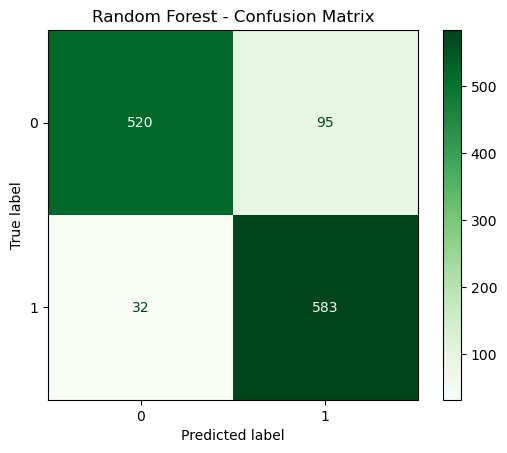

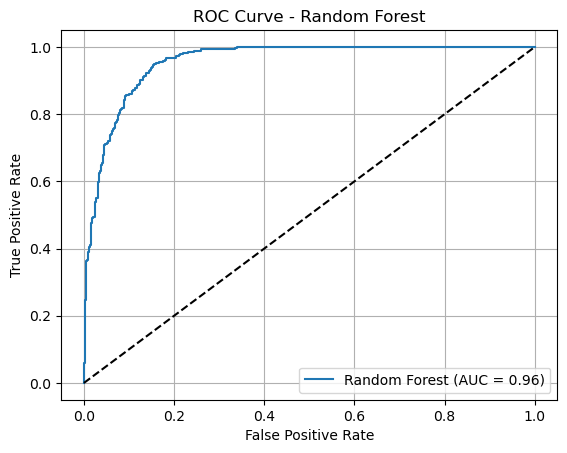

In [25]:
# Plot Confusion Matrix - Random Forest
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, cmap="Greens", ax=ax)
ax.set_title("Random Forest - Confusion Matrix")
plt.show()

# Plot ROC Curve - Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 6],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='f1')

In [27]:
# Best XGBoost model
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test)
xgb_proba = xgb_best.predict_proba(X_test)[:, 1]

print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))


Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       615
           1       0.85      0.94      0.89       615

    accuracy                           0.89      1230
   macro avg       0.89      0.89      0.89      1230
weighted avg       0.89      0.89      0.89      1230

ROC-AUC: 0.9531561900984864
Confusion Matrix:
 [[512 103]
 [ 37 578]]


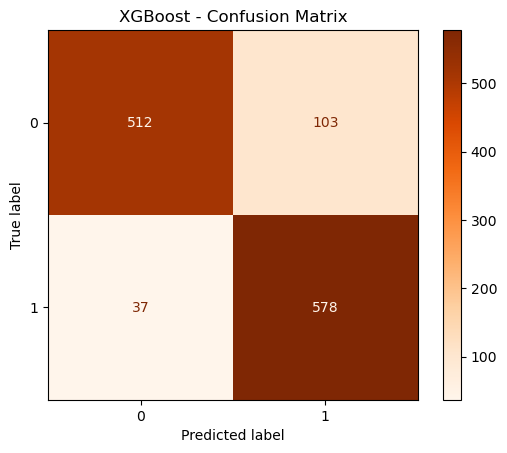

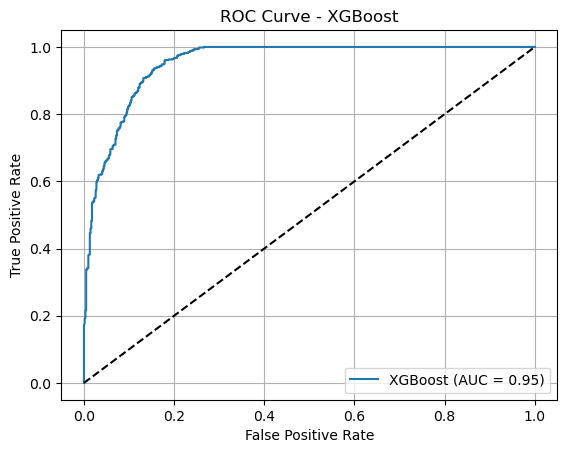

In [28]:
# Plot Confusion Matrix - XGBoost
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred, cmap="Oranges", ax=ax)
ax.set_title("XGBoost - Confusion Matrix")
plt.show()

# Plot ROC Curve - XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

MLP

In [30]:


# Fix random seed for reproducibility
np.random.seed(42)

def build_model(neurons=64, dropout_rate=0.6, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model





In [31]:
# Wrap the model using scikeras
model = KerasClassifier(model=build_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    "model__neurons": [32, 64],
    "model__dropout_rate": [0.3, 0.6],
    "model__optimizer": ['adam', 'rmsprop'],
    "batch_size": [32, 64],
    "epochs": [30, 50 ]
}

# Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_result = grid.fit(X_train, y_train)


In [32]:
# Evaluate the best model
best_mlp = grid_result.best_estimator_

# Get predicted probabilities for the positive class
y_proba = best_mlp.predict_proba(X_test)[:, 1]

# Convert predicted classes
y_pred = (y_proba > 0.5).astype("int32")

# Evaluate
print("Best MLP Parameters:", grid_result.best_params_)
print("MLP Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best MLP Parameters: {'batch_size': 64, 'epochs': 30, 'model__dropout_rate': 0.6, 'model__neurons': 32, 'model__optimizer': 'rmsprop'}
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88       615
           1       0.85      0.94      0.89       615

    accuracy                           0.89      1230
   macro avg       0.89      0.89      0.89      1230
weighted avg       0.89      0.89      0.89      1230

ROC-AUC: 0.9522004098089761
Confusion Matrix:
 [[510 105]
 [ 35 580]]


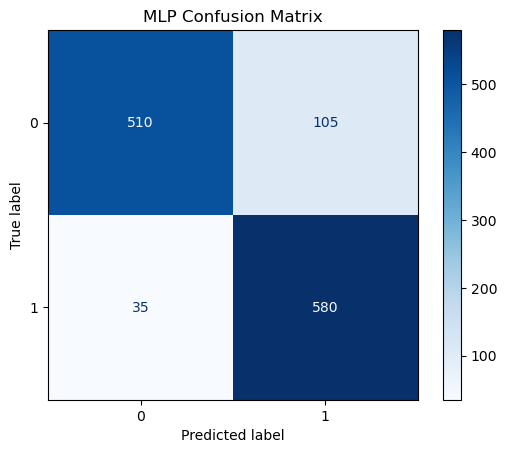

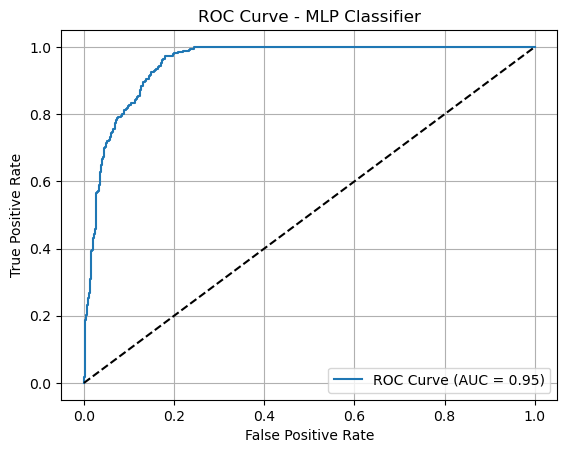

In [33]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [34]:
# Ignore warnings
warnings.filterwarnings("ignore")

# Generate dummy dataset (replace with actual preprocessed dataset in real use)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=2000, n_features=50, n_informative=20, n_classes=2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define Optuna objective
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "verbose": 0,
        "random_seed": 42
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=30)

    preds = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, preds)

# Run tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Best model training
best_params = study.best_params
best_params.update({"eval_metric": "AUC", "loss_function": "Logloss", "verbose": 0, "random_seed": 42})
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=30)

# Final evaluation
y_pred = final_model.predict(X_valid)
y_proba = final_model.predict_proba(X_valid)[:, 1]
report = classification_report(y_valid, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_proba)





[I 2025-07-02 21:34:50,755] A new study created in memory with name: no-name-fe8de773-7881-4a72-a292-e566794e126e
[I 2025-07-02 21:34:51,024] Trial 0 finished with value: 0.8700111111111112 and parameters: {'iterations': 309, 'depth': 6, 'learning_rate': 0.0011101128392423287, 'l2_leaf_reg': 6.223596813435681, 'border_count': 202, 'random_strength': 4.97078470264924, 'bagging_temperature': 0.4433764183046641}. Best is trial 0 with value: 0.8700111111111112.
[I 2025-07-02 21:34:51,544] Trial 1 finished with value: 0.9261555555555556 and parameters: {'iterations': 997, 'depth': 5, 'learning_rate': 0.004198002025807081, 'l2_leaf_reg': 7.4640688298329945, 'border_count': 33, 'random_strength': 1.3047183690067206, 'bagging_temperature': 0.5376591054826466}. Best is trial 1 with value: 0.9261555555555556.
[I 2025-07-02 21:34:51,599] Trial 2 finished with value: 0.8484333333333334 and parameters: {'iterations': 741, 'depth': 5, 'learning_rate': 0.002405110995228767, 'l2_leaf_reg': 9.719316396


Classification Report:
              precision    recall  f1-score  support
0              0.922819  0.916667  0.919732   300.00
1              0.917219  0.923333  0.920266   300.00
accuracy       0.920000  0.920000  0.920000     0.92
macro avg      0.920019  0.920000  0.919999   600.00
weighted avg   0.920019  0.920000  0.919999   600.00

Confusion Matrix:
[[275  25]
 [ 23 277]]

ROC-AUC Score: 0.9741444444444445

Best Hyperparameters from Optuna:
{'iterations': 899, 'depth': 7, 'learning_rate': 0.08812986885837212, 'l2_leaf_reg': 4.948930221653062, 'border_count': 227, 'random_strength': 0.9483997763910783, 'bagging_temperature': 0.5651297090444576}


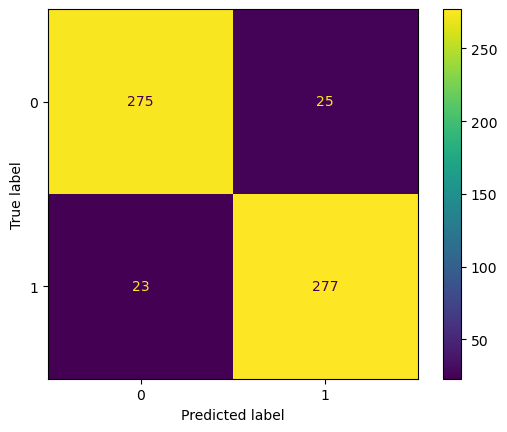

In [35]:
# Print classification report
print("\nClassification Report:")
print(pd.DataFrame(report).transpose())

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Print ROC-AUC score
print("\nROC-AUC Score:", roc_auc)

# Print best hyperparameters
print("\nBest Hyperparameters from Optuna:")
print(study.best_params)


ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)

In [36]:
# Ensure X_test has only numeric data
X_test_clean = X_test.copy()

# Convert all columns to numeric (if possible)
for col in X_test_clean.columns:
    if X_test_clean[col].dtype == 'object':
        try:
            X_test_clean[col] = pd.to_numeric(X_test_clean[col], errors='coerce')
        except:
            pass

# Drop any remaining non-numeric columns
X_test_clean = X_test_clean.select_dtypes(include=[np.number])

# Drop rows with any NaNs (SHAP cannot handle them)
X_test_clean = X_test_clean.dropna()


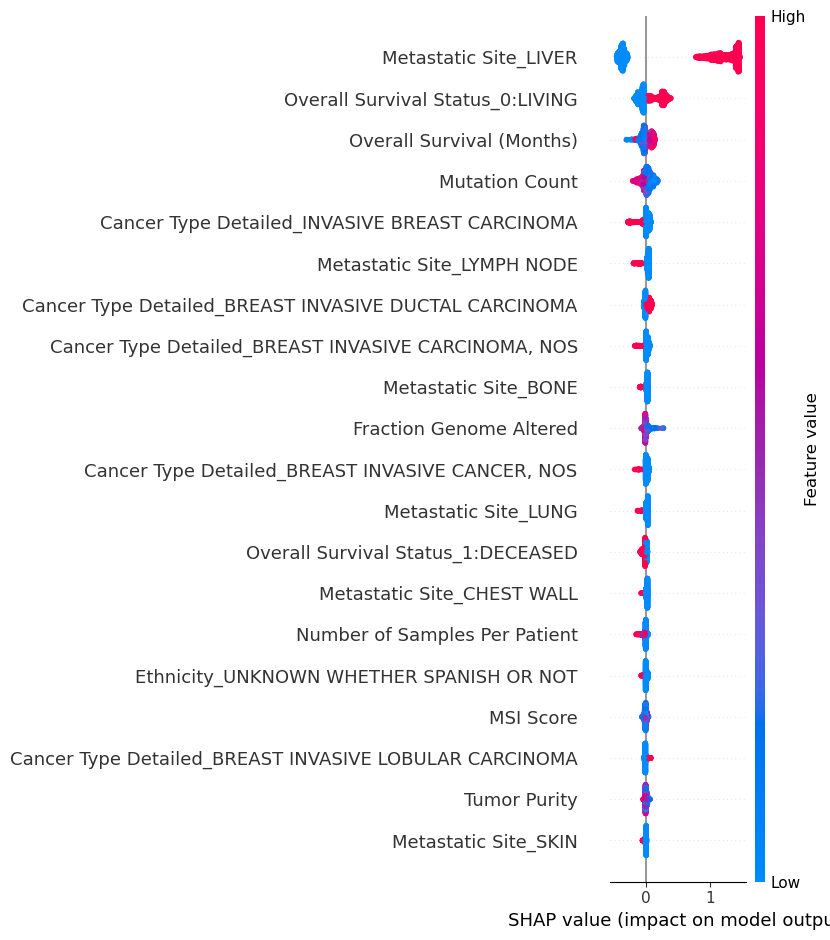

In [37]:
import shap
explainer = shap.Explainer(xgb_best, X_train)
shap_values = explainer(X_test, check_additivity=False)


shap.summary_plot(shap_values, X_test)


shap.plots.force(shap_values[0])         
   


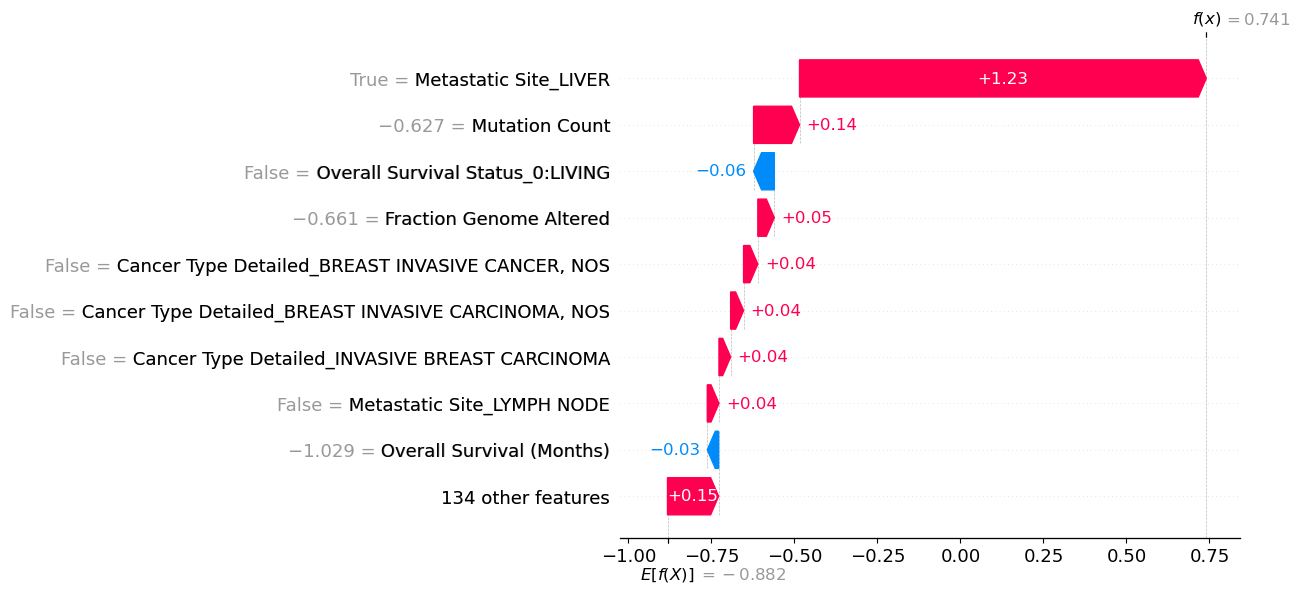

In [38]:
shap.plots.waterfall(shap_values[0])  

 97%|=================== | 2376/2460 [00:13<00:00]       

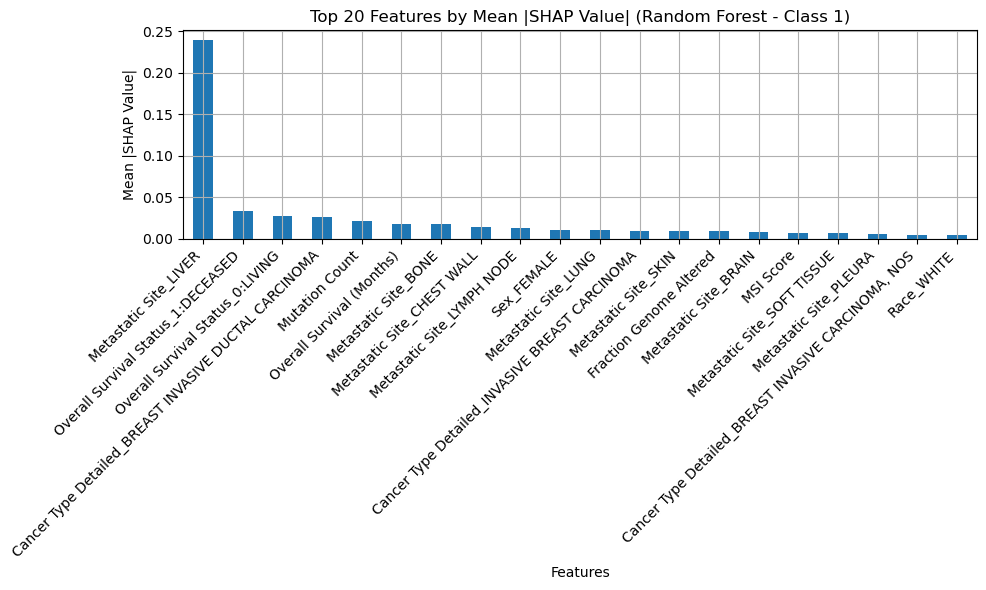

In [40]:
rf_explainer = shap.Explainer(rf_best, X_train)
rf_shap_values = rf_explainer(X_test, check_additivity=False)

shap_values_class1 = rf_shap_values.values[:, :, 1]

# Compute mean absolute SHAP value per feature
mean_shap = np.abs(shap_values_class1).mean(axis=0)

# Create pandas Series for bar plot
shap_df = pd.Series(mean_shap, index=rf_shap_values.feature_names).sort_values(ascending=False)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
shap_df.head(20).plot(kind='bar')
plt.title("Top 20 Features by Mean |SHAP Value| (Random Forest - Class 1)")
plt.ylabel("Mean |SHAP Value|")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()


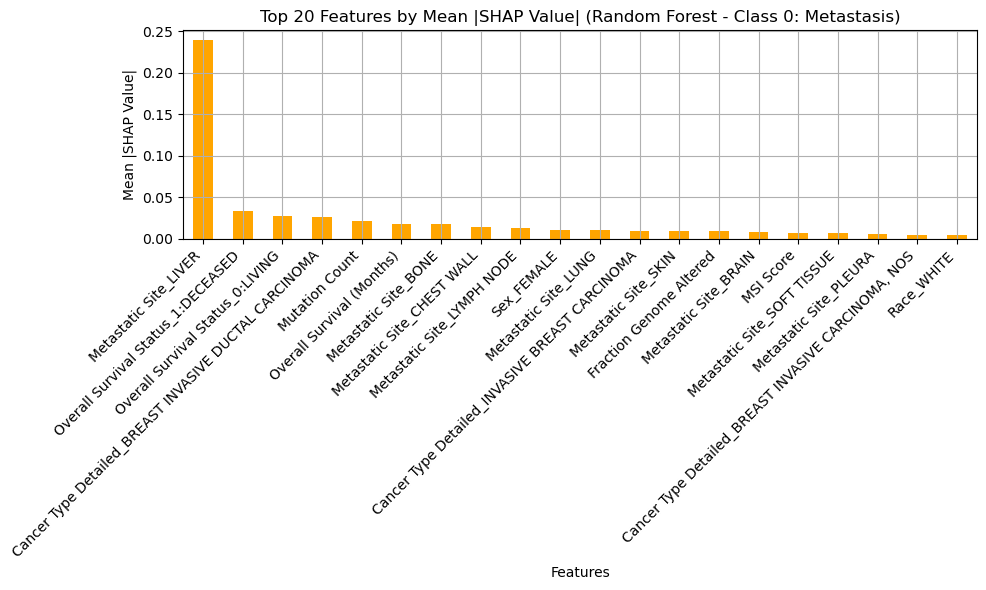

In [42]:


# Get SHAP values for class 0 (Metastasis)
shap_values_class0 = rf_shap_values.values[:, :, 0]  # shape: (n_samples, n_features)

# Compute mean absolute SHAP value per feature for class 0
mean_shap_class0 = np.abs(shap_values_class0).mean(axis=0)

# Create pandas Series for plotting
shap_df_class0 = pd.Series(mean_shap_class0, index=rf_shap_values.feature_names).sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
shap_df_class0.head(20).plot(kind='bar', color='orange')
plt.title("Top 20 Features by Mean |SHAP Value| (Random Forest - Class 0: Metastasis)")
plt.ylabel("Mean |SHAP Value|")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()
